<a href="https://colab.research.google.com/github/HakureiKirisame/Portfolio-Optimization-Using-Python-Pyomo/blob/main/portfolio_maximization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Decision Modeling Project** 


# Basic info

Market Cap for Stocks >= $10Billion 
* Apple (AAPL)
* Google (GOOG)
* United Health (UEEC)
* Microsoft (MSFT)

Market Cap for Cryptocurrency >= $40Billion
* BTC (BTC-USD)
* ETH (ETH-USD)
* USDT (USDT-USD)
* BNB (BNB-USD)


Modern Portfolio Theory:

* Assuming risk-averse
* A high variance asset can be combined with other uncorrelarted assets to build up a portfolio with lower variance on return

Efficient Frontier:

* Graph with return on Y-axis, volatility on X-axis, shows the set of optimal portfolios that offer the highest expected return for a given risk level or the lowest risk for a given level of expected return.

## Set up working environment

In [ ]:
#installing yahoo finance package
#Importing modules for data analysis
#!pip install fix-yahoo-finance==0.1.30
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import datetime

     |████████████████████████████████| 63 kB 989 kB/s 
     |████████████████████████████████| 6.4 MB 7.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
#installing pyomo
!pip install -q pyomo
from pyomo.environ import *

try:
    import google.colab
    try:
        from pyomo.environ import *
    except:
        !pip install -q pyomo
    if not 'ipopt_executable' in vars():
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        ipopt_executable = '/content/ipopt' 
except:
    pass

     |████████████████████████████████| 9.6 MB 4.6 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 


## Import & manage the data

`Requirement`: daily data for your assets from January 1, 2017, to December 31, 2021

In [ ]:
#Assigning ticker for stocks between the start and end date
Apple=yf.download('AAPL',start='2017-01-01',end='2021-12-31',group_by='ticker')
Google=yf.download('GOOG',start='2017-01-01',end='2021-12-31',group_by='ticker')
United_Health=yf.download('UEEC',start='2017-01-01',end='2021-12-31',group_by='ticker')
Microsoft=yf.download('MSFT',start='2017-01-01',end='2021-12-31',group_by='ticker')

#Assigning ticker for Crypto Currency between the start and end date
BTC=yf.download('BTC-USD',start='2017-01-01',end='2021-12-31',group_by='ticker')
ETH=yf.download('ETH-USD',start='2017-01-01',end='2021-12-31',group_by='ticker')
USDT=yf.download('USDT-USD',start='2017-01-01',end='2021-12-31',group_by='ticker')
BNB=yf.download('BNB-USD',start='2017-01-01',end='2021-12-31',group_by='ticker')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
#Renaming Columns
Apple.rename(columns={'Adj Close':'Apple'},inplace=True)
Google.rename(columns={'Adj Close':'Google'},inplace=True)
United_Health.rename(columns={'Adj Close':'United_Health'},inplace=True)
Microsoft.rename(columns={'Adj Close':'Microsoft'},inplace=True)
BTC.rename(columns={'Adj Close':'BTC'},inplace=True)
ETH.rename(columns={'Adj Close':'ETH'},inplace=True)
USDT.rename(columns={'Adj Close':'USDT'},inplace=True)
BNB.rename(columns={'Adj Close':'BNB'},inplace=True)

We are going to optimize the return on the daily/weekly/quarterly scale, hereby we are going to calculate the weekly return and volatility of the portfolio. We will use the `Adj Close` as the closing price of the desinated assest on the given day.

In [ ]:
#Creating Dataframe with adjacent closing values for each stock and cryptocurrencies
Prices=[
       Apple['Apple'],
       Google['Google'],
       United_Health['United_Health'],
       Microsoft['Microsoft'],
       BTC['BTC'],
       ETH['ETH'],
       USDT['USDT'],
       BNB['BNB'],
]
Prices=pd.DataFrame(Prices).transpose()
Prices.fillna(0,inplace=True)
Prices.head()

,Apple,Google,United_Health,Microsoft,BTC,ETH,USDT,BNB
Date,,,,,,,,
2017-01-01,0.000000,0.000000,0.000,0.000000,998.325012,0.0,0.0,0.0
2017-01-02,0.000000,0.000000,0.000,0.000000,1021.750000,0.0,0.0,0.0
2017-01-03,27.297693,786.140015,0.090,58.065453,1043.839966,0.0,0.0,0.0
2017-01-04,27.267139,786.900024,0.090,57.805653,1154.729980,0.0,0.0,0.0
2017-01-05,27.405804,794.020020,0.089,57.805653,1013.380005,0.0,0.0,0.0


## Percentage change of prices (ΔP) & Return

Since the log of return is time additive, we will take the log of the price percentage change.



In [ ]:
from IPython.core.pylabtools import figsize
#impute NaN and Inf, -Inf
#Calculating log of the price percentage change between the current and prior element
Log_Delta_Prices=Prices.pct_change().apply(lambda x: np.log(1+x))
Log_Delta_Prices.replace([np.inf, -np.inf], np.nan, inplace=True)
Log_Delta_Prices.fillna(0,inplace=True)
print('Logged ΔPrices are:\n',Log_Delta_Prices.head())
print('\n')

#Return
Returns=Log_Delta_Prices.mean()
print('Expected Returns are:\n',Returns)
#plot


Logged ΔPrices are:
                Apple    Google  United_Health  Microsoft       BTC  ETH  USDT  \
Date                                                                            
2017-01-01  0.000000  0.000000       0.000000   0.000000  0.000000  0.0   0.0   
2017-01-02  0.000000  0.000000       0.000000   0.000000  0.023193  0.0   0.0   
2017-01-03  0.000000  0.000000       0.000000   0.000000  0.021389  0.0   0.0   
2017-01-04 -0.001120  0.000966       0.000000  -0.004484  0.100960  0.0   0.0   
2017-01-05  0.005073  0.009007      -0.011173   0.000000 -0.130575  0.0   0.0   

            BNB  
Date             
2017-01-01  0.0  
2017-01-02  0.0  
2017-01-03  0.0  
2017-01-04  0.0  
2017-01-05  0.0  


Expected Returns are:
 Apple            0.000671
Google           0.000670
United_Health    0.000590
Microsoft        0.000876
BTC              0.002101
ETH              0.001336
USDT            -0.000004
BNB              0.003039
dtype: float64


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Exploratory Data Analysis



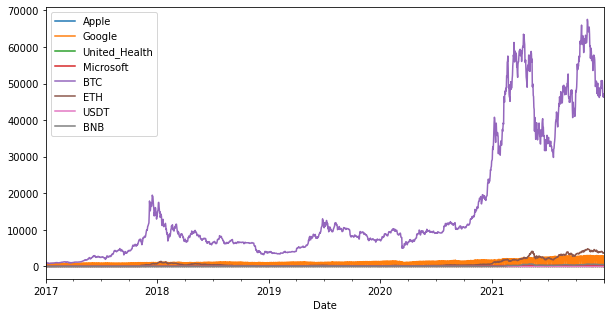

In [ ]:
Prices.plot(figsize = (10, 5))
plt.show()

##Visualize the time series

As is visible in the time series below:
Apple, Google and Microsoft display a clear upward trend. United Health prices display spodaric peaks in the prices.
For the Cryptocurrencies, BTC and ETH display an upward trend. USDT shows a upward trend till 2018, and then remains varied till 2021. BNB is constant till 2021, after which it displays a sharp upward spike in the price.

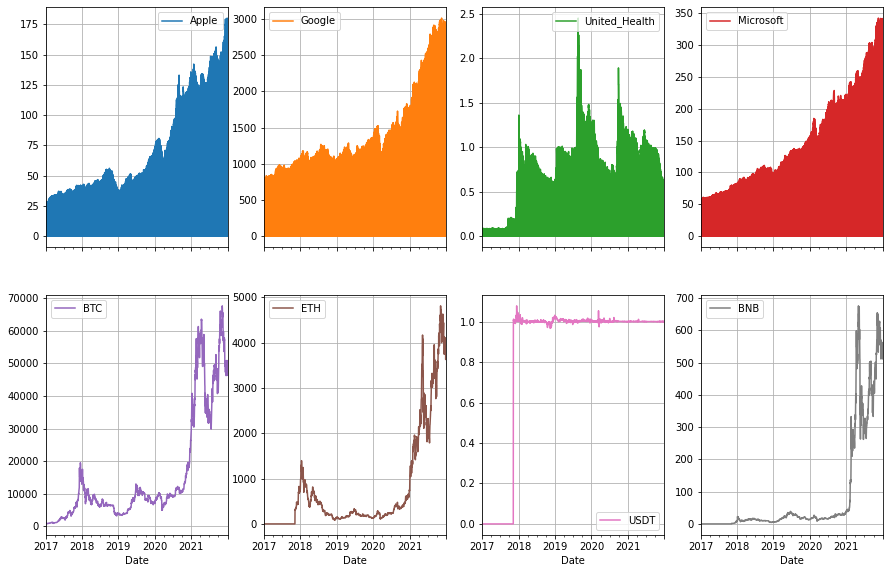

In [ ]:
Prices.plot(subplots=True,
        grid=True, 
        layout=(3,4),
         figsize=(15,15))
plt.show()

## Variance & Volatility

* Volatility is the standard deviation of the stock.

In [ ]:
# Variance
Variances=[]
for i in range(8):
  Variances.append(Log_Delta_Prices.iloc[:,i].var())

Variances=pd.DataFrame(Variances).transpose()
print('Variances are:\n',Variances)
# Volatility
Volatilities=[]
for i in range(8):
  Volatilities.append(Log_Delta_Prices.iloc[:,i].std())

Volatilities=pd.DataFrame(Volatilities).transpose()
print('Volatilities are:\n',Volatilities)

Variances are:
           0         1         2         3         4         5         6  \
0  0.000181  0.000147  0.001946  0.000145  0.001787  0.002297  0.000021   

          7  
0  0.003246  
Volatilities are:
           0         1        2         3        4         5         6  \
0  0.013461  0.012136  0.04411  0.012052  0.04227  0.047931  0.004541   

          7  
0  0.056978  


## Covariance Matrix & Correlation Matrix

In [ ]:
#Covariance matrix
Covariance=Log_Delta_Prices.cov()

In [ ]:
#Covariance Plot
Covariance.style.background_gradient(cmap='summer')

,Apple,Google,United_Health,Microsoft,BTC,ETH,USDT,BNB
Apple,0.000181,0.000103,0.000011,0.000116,0.000078,0.000103,-0.000006,0.000105
Google,0.000103,0.000147,0.000008,0.000111,0.000069,0.000090,-0.000006,0.000079
United_Health,0.000011,0.000008,0.001946,0.000008,0.000116,0.000038,-0.000009,0.000031
Microsoft,0.000116,0.000111,0.000008,0.000145,0.000079,0.000105,-0.000007,0.000102
BTC,0.000078,0.000069,0.000116,0.000079,0.001787,0.001404,0.000001,0.001407
ETH,0.000103,0.000090,0.000038,0.000105,0.001404,0.002297,-0.000007,0.001769
USDT,-0.000006,-0.000006,-0.000009,-0.000007,0.000001,-0.000007,0.000021,-0.000013
BNB,0.000105,0.000079,0.000031,0.000102,0.001407,0.001769,-0.000013,0.003246


In [ ]:
#Correlation matrix
Correlation=Log_Delta_Prices.corr()

In [ ]:
#Correlation Plot
Correlation.style.background_gradient(cmap='summer')

,Apple,Google,United_Health,Microsoft,BTC,ETH,USDT,BNB
Apple,1.000000,0.629273,0.018728,0.717424,0.136922,0.159755,-0.093460,0.136661
Google,0.629273,1.000000,0.015875,0.760520,0.134833,0.154021,-0.103592,0.114850
United_Health,0.018728,0.015875,1.000000,0.014568,0.062111,0.017820,-0.045109,0.012371
Microsoft,0.717424,0.760520,0.014568,1.000000,0.155516,0.181421,-0.123422,0.149251
BTC,0.136922,0.134833,0.062111,0.155516,1.000000,0.693011,0.005448,0.583989
ETH,0.159755,0.154021,0.017820,0.181421,0.693011,1.000000,-0.032963,0.647899
USDT,-0.093460,-0.103592,-0.045109,-0.123422,0.005448,-0.032963,1.000000,-0.051561
BNB,0.136661,0.114850,0.012371,0.149251,0.583989,0.647899,-0.051561,1.000000


# Building Optimization Model

Objectives:

* 1.All proportions of stocks and crypto currencies should sum up to 1
* 3.At least 100 risk ceilings
* 4.Show shape of the efficient frontier



## Declare Model Variables & Objective Function

In [ ]:
from pyomo.environ import *
m = ConcreteModel()
num_stock=4
# Defining variables for stocks and cryptocurrencies
m.Apple = Var(within=NonNegativeReals, bounds=(0,1))
m.Google = Var(within=NonNegativeReals, bounds=(0,1))
m.United_Health = Var(within=NonNegativeReals, bounds=(0,1))
m.Microsoft = Var(within=NonNegativeReals, bounds=(0,1))
m.BTC = Var(within=NonNegativeReals, bounds=(0,1))
m.ETH = Var(within=NonNegativeReals, bounds=(0,1))
m.USDT = Var(within=NonNegativeReals, bounds=(0,1))
m.BNB = Var(within=NonNegativeReals, bounds=(0,1))
m.x=Var(range(4),range(2),within=Binary)
m.stock_index=[m.Apple,m.Google,m.United_Health,m.Microsoft]
m.x.pprint()

x : Size=8, Index=x_index
    Key    : Lower : Value : Upper : Fixed : Stale : Domain
    (0, 0) :     0 :  None :     1 : False :  True : Binary
    (0, 1) :     0 :  None :     1 : False :  True : Binary
    (1, 0) :     0 :  None :     1 : False :  True : Binary
    (1, 1) :     0 :  None :     1 : False :  True : Binary
    (2, 0) :     0 :  None :     1 : False :  True : Binary
    (2, 1) :     0 :  None :     1 : False :  True : Binary
    (3, 0) :     0 :  None :     1 : False :  True : Binary
    (3, 1) :     0 :  None :     1 : False :  True : Binary


In [ ]:
# Declare Objectives
m.objective= Objective(expr=
                       m.Apple*Returns[0]+
                       m.Google*Returns[1]+
                       m.United_Health*Returns[2]+
                       m.Microsoft*Returns[3]+
                       m.BTC*Returns[4]+
                       m.ETH*Returns[5]+
                       m.USDT*Returns[6]+
                       m.BNB*Returns[7],
                       sense=maximize) # Since we need to maximize returns

## Declare Model Constraints & Risk

In [ ]:
# Declaring Constraints
# Sum of all proportions = 1
m.sum_proportions = Constraint(expr=
                                m.Apple+
                                m.Google+
                                m.United_Health+
                                m.Microsoft+
                                m.BTC+
                                m.ETH+
                                m.USDT+
                                m.BNB==1)


In [ ]:
# Declaring Risk
max_risk=0.0015
# Defining Risk Calculation
def calc_risk():
  proportions=[m.Apple,m.Google,m.United_Health,m.Microsoft,m.BTC,m.ETH,m.USDT,m.BNB]
  risk_matrix=[]
  for index, col in enumerate(Covariance.columns):
    i = 0
    risk = []
    for row in Covariance[col]:
      risk.append(proportions[index]*row*proportions[i])
      i +=1
    risk_matrix.append(risk)
  risk_matrix = pd.DataFrame(risk_matrix)
  return risk_matrix.sum().sum()
#risk limits
risk_limits = np.arange(0.0001, 0.005, 0.000011)


## Run model

In [ ]:
param_analysis={}
returns={}

In [ ]:
from sys import executable
for r in risk_limits:
  m.total_risk=Constraint(expr=calc_risk()<=r)
  result=SolverFactory('ipopt',executable=ipopt_executable).solve(m).write()
  param_analysis[r]=[m.Apple(),m.Google(),m.United_Health(),m.Microsoft(),m.BTC(),m.ETH(),m.USDT(),m.BNB()]
  returns[r]= m.Apple()*Returns[0]+m.Google()*Returns[1]+m.United_Health()*Returns[2]+m.Microsoft()*Returns[3]+m.BTC()*Returns[4]+m.ETH()*Returns[5]+m.USDT()*Returns[6]+m.BNB()*Returns[7]

### Allocation & Efficient Frontier

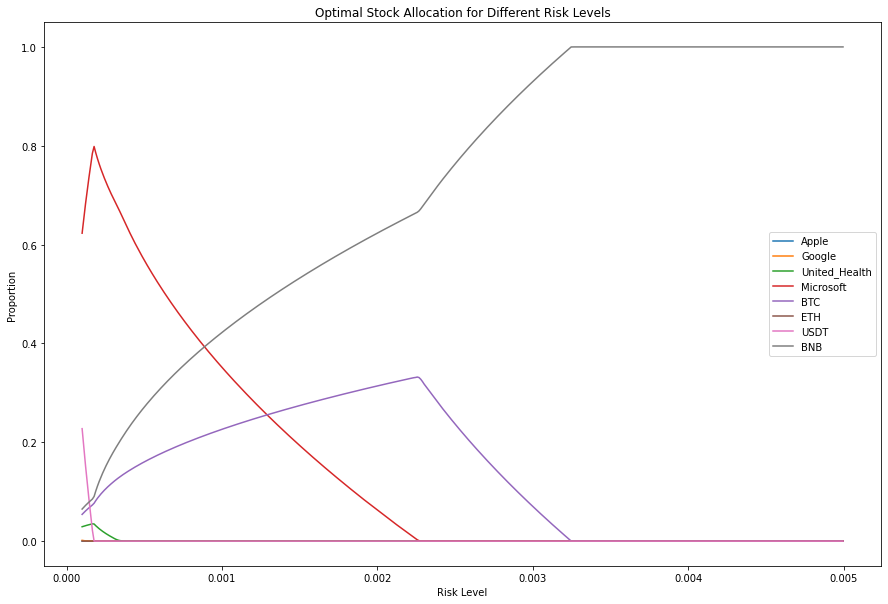

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = [ 'Apple', 'Google', 'United_Health', 'Microsoft', 'BTC','ETH','USDT','BNB']
param_analysis.plot(figsize=(15,10))
plt.xlabel('Risk Level')
plt.ylabel('Proportion')
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

The plot is smooth because we have used log price as the return.

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
#print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

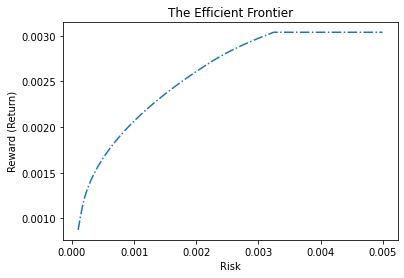

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

# Simulation

For the Monte Carlo simulation below, only `four` assets will be chosen to build up the portfolio.

* four assets will be chosen

## Select designated assets

In [ ]:
temp=param_analysis.round(4)
# according to the graph, the portfolio below satisfied the condition
print(temp.loc[(temp['Microsoft']!=0)&(temp['BNB']!=0)&(temp['BTC']!=0)&(temp['United_Health']!=0)&(temp['Google']==0)&(temp['USDT']==0)])
#selected portfolio
temp2=temp.loc[(temp['Microsoft']!=0)&(temp['BNB']!=0)&(temp['BTC']!=0)&(temp['United_Health']!=0)&(temp['Google']==0)&(temp['USDT']==0)]
selected_portfolio=temp2.iloc[-1]

In the simulation, based on our portfolio graph, we will use `United Health`,`Microsoft`,`BTC`,`BNB` as the components of our portfolio. We will perform a Monte Carlo Simulation on the portfolio with highest expected return.

### Asset Attributes

In [ ]:
#expected return
selected_asset_exp_return=Log_Delta_Prices[['United_Health','Microsoft','BTC','BNB']]
selected_asset_exp_return=selected_asset_exp_return.mean()
#expected volatility
selected_volatilities=Volatilities[[2,3,4,7]]
selected_volatilities.rename(columns={2:'United_Health',3:'Microsoft',4:'BTC',7:'BNB'},inplace=True) 
selected_volatilities
#covariance
selected_cov=Log_Delta_Prices[['United_Health','Microsoft','BTC','BNB']].cov()
selected_cov
#proportion(weight)
selected_portfolio=pd.DataFrame(selected_portfolio).transpose()
selected_weight=selected_portfolio[['United_Health','Microsoft','BTC','BNB']]
selected_weight.values
#correlation
selected_cor=Log_Delta_Prices[['United_Health','Microsoft','BTC','BNB']].corr()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Simulation construction

For the simulation we will run a 10000-step loop. Each iteration, the expected return will be affected by the volatilities.

In [ ]:
n=10000
portfolio_return=[]
portfolio_volatility=[]
portfolio_weights=[]
for i in range(n):
  #calculate random volatility based on covariance
  weights=np.random.random(4)
  weights=weights/sum(weights)
  portfolio_weights.append(weights)
  #return after applying volatility
  temp=np.dot(weights,selected_asset_exp_return)
  portfolio_return.append(temp)
  
  #total volatility
  var=selected_cov.mul(weights,axis=0).mul(weights,axis=1).sum().sum()
  temp2=np.sqrt(var)
  portfolio_volatility.append(temp2)

#np.random.multivariate_normal(selected_weight.values.flatten(),selected_cov,size=1)

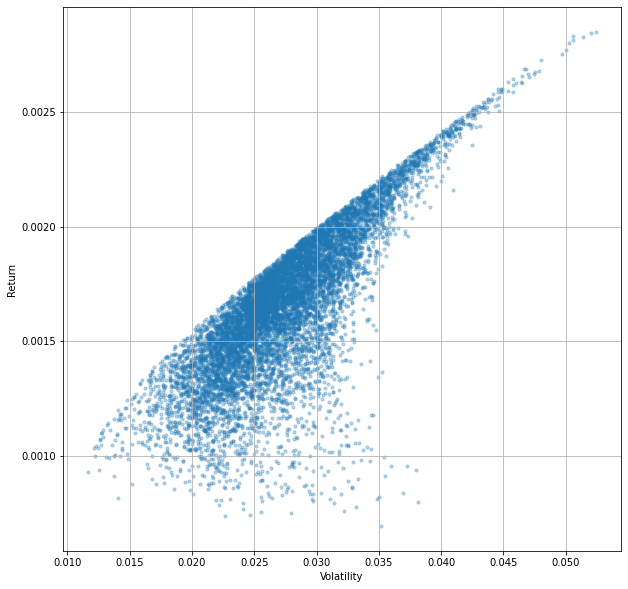

In [ ]:
portfolio=pd.DataFrame([portfolio_return,portfolio_volatility]).transpose()
portfolio.head()
portfolio.rename(columns={0:'Return',1:'Volatility'},inplace=True)
portfolio.plot.scatter(x='Volatility',y='Return',marker='o',s=10,alpha=0.3,grid=True,figsize=[10,10])
plt.show()

In [ ]:
#min volatility
selected_min_vol=portfolio[portfolio['Volatility']==portfolio['Volatility'].min()]
print('portfolio with smallest volatility:\n',selected_min_vol)
#highest sharpe ratio
rf=0.01

temp=pd.DataFrame(((portfolio['Return']-rf)/portfolio['Volatility']))
temp.rename(columns={0:'value'},inplace=True)
optimal_portfolio=portfolio[portfolio.index==temp[temp['value']==float(temp['value'].max())].index[0]]

print('portfolio with highest sharpe ratio (return):\n',optimal_portfolio)

portfolio with smallest volatility:
         Return  Volatility
2640  0.000927    0.011672
portfolio with highest sharpe ratio (return):
        Return  Volatility
2854  0.00285    0.052415


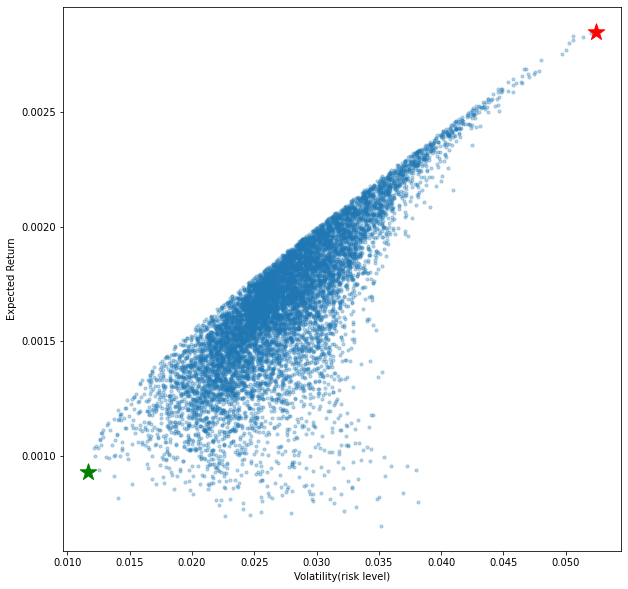

In [ ]:
plt.subplots(figsize=(10,10))
plt.scatter(x=portfolio['Volatility'],y=portfolio['Return'],marker='o',s=10,alpha=0.3,)
plt.scatter(selected_min_vol['Volatility'],selected_min_vol['Return'],marker='*',color='g',s=300)
plt.scatter(optimal_portfolio['Volatility'],optimal_portfolio['Return'],marker='*',color='r',s=300)
plt.xlabel('Volatility(risk level)')
plt.ylabel('Expected Return')
plt.show()

* The red star above represents the portfolio with highest sharpe ratio, where the return is optimized.

* The green star above represent the portfolio with lowest volatility, where the risk is minimized.


# Analysis

## Portfolio Performance

According to the chart above we are on track with a healthy portfolio meeting all the constraints for the project.

In [ ]:
#Assigning ticker for stocks between the start and end date
United_Health_m=yf.download('UEEC',start='2021-01-01',end='2021-12-02',interval='1mo',group_by='ticker')
Microsoft_m=yf.download('MSFT',start='2021-01-01',end='2021-12-02',interval='1mo',group_by='ticker')
BTC_m=yf.download('BTC-USD',start='2021-01-01',end='2021-12-02',interval='1mo',group_by='ticker')
BNB_m=yf.download('BNB-USD',start='2021-01-01',end='2021-12-02',interval='1mo',group_by='ticker')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
Microsoft_m=Microsoft_m.dropna(how='all')

In [ ]:
#Renaming Columns
United_Health_m.rename(columns={'Adj Close':'United_Health'},inplace=True)
Microsoft_m.rename(columns={'Adj Close':'Microsoft'},inplace=True)
BTC_m.rename(columns={'Adj Close':'BTC'},inplace=True)
BNB_m.rename(columns={'Adj Close':'BNB'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#Creating Dataframe with adjacent closing values for each stock and cryptocurrencies
Prices_m=[
       United_Health_m['United_Health'],
       Microsoft_m['Microsoft'],
       BTC_m['BTC'],
       BNB_m['BNB'],
]
Prices_m=pd.DataFrame(Prices_m).transpose()
Prices_m

,United_Health,Microsoft,BTC,BNB
Date,,,,
2021-01-01,1.080,229.557144,33114.359375,44.275993
2021-02-01,1.140,229.972809,45137.769531,209.574402
2021-03-01,1.050,233.865067,58918.832031,302.063446
2021-04-01,0.845,250.142471,57750.175781,624.080566
2021-05-01,1.003,247.662674,37332.855469,354.329346
2021-06-01,1.030,269.331726,35040.835938,303.295868
2021-07-01,1.000,283.260620,41626.195312,333.549591
2021-08-01,0.980,300.132355,47166.687500,464.418732
2021-09-01,0.990,280.824524,43790.894531,387.057343


In [ ]:
from IPython.core.pylabtools import figsize
#impute NaN and Inf, -Inf
#Calculating log of the price percentage change between the current and prior element
Log_Delta_Prices_m=Prices_m.pct_change().apply(lambda x: np.log(1+x))
Log_Delta_Prices_m.replace([np.inf, -np.inf], np.nan, inplace=True)
Log_Delta_Prices_m.fillna(0,inplace=True)
print('Logged ΔPrices are:\n',Log_Delta_Prices_m.head())
print('\n')

#Return
Returns_m=Log_Delta_Prices_m.mean()
print('Expected Returns are:\n',Returns_m)


Logged ΔPrices are:
             United_Health  Microsoft       BTC       BNB
Date                                                    
2021-01-01       0.000000   0.000000  0.000000  0.000000
2021-02-01       0.054067   0.001809  0.309752  1.554636
2021-03-01      -0.082238   0.016783  0.266441  0.365558
2021-04-01      -0.217209   0.067286 -0.020034  0.725642
2021-05-01       0.171414  -0.009963 -0.436253 -0.566053


Expected Returns are:
 United_Health   -0.050383
Microsoft        0.031654
BTC              0.027943
BNB              0.203943
dtype: float64


## Indicator Performance

In [ ]:
#indicator
# according to the Dow Chart below, the portfolio below satisfied the condition
Dow=yf.download('DOW',start='2021-01-01',end='2021-12-02',interval='1mo',group_by='ticker')
Dow.rename(columns={'Adj Close':'Dow'},inplace=True)
Dow=Dow.dropna(how='all')

Dow_Prices=[
       
       Dow['Dow']
]
Dow_Prices=pd.DataFrame(Dow_Prices).transpose()
Dow_Prices.fillna(0,inplace=True)
Dow_Prices

[*********************100%***********************]  1 of 1 completed


,Dow
Date,
2021-01-01,49.066193
2021-02-01,56.071594
2021-03-01,61.120548
2021-04-01,59.744049
2021-05-01,65.403000
2021-06-01,61.104473
2021-07-01,60.022980
2021-08-01,60.737541
2021-09-01,56.182652


In [ ]:
from IPython.core.pylabtools import figsize
#impute NaN and Inf, -Inf
#Calculating log of the price percentage change between the current and prior element
Log_Delta_Prices_dow=Dow_Prices.pct_change().apply(lambda x: np.log(1+x))
Log_Delta_Prices_dow.replace([np.inf, -np.inf], np.nan, inplace=True)
Log_Delta_Prices_dow.fillna(0,inplace=True)
print('Logged ΔPrices are:\n',Log_Delta_Prices_dow.head())
print('\n')

#Return
Returns_dow=Log_Delta_Prices_dow.mean()
print('Expected Returns are:\n',Returns_dow)

#Volatility
Vol_dow=Log_Delta_Prices_dow.std()
print('Expected Returns are:\n',Vol_dow)

Logged ΔPrices are:
                  Dow
Date                
2021-01-01  0.000000
2021-02-01  0.133459
2021-03-01  0.086219
2021-04-01 -0.022779
2021-05-01  0.090499


Expected Returns are:
 Dow    0.01108
dtype: float64
Expected Returns are:
 Dow    0.065183
dtype: float64


## New Constraints

In [ ]:
# Obj 2
m.stock_amount_constraint= ConstraintList()

for q in range(2):
  stock_amount_expr=0
  for p in range(num_stock):
    stock_amount_expr+=m.x[p,q]
    m.stock_amount_constraint.add(expr=stock_amount_expr>=2)
#add percentage constraint
m.stock_percentage_constraint=ConstraintList()
for q in range(2):
  percentage_expr=0
  for p in range(num_stock):
    percentage_expr+=m.x[p,q]*m.stock_index[p]
    m.stock_percentage_constraint.add(expr=percentage_expr>=0.1)

In [ ]:
param_analysis={}
returns={}

In [ ]:
m.pprint()

5 Set Declarations
    stock_amount_constraint_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    8 : {1, 2, 3, 4, 5, 6, 7, 8}
    stock_percentage_constraint_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    8 : {1, 2, 3, 4, 5, 6, 7, 8}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :    8 : {(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {0, 1, 2, 3}
    x_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}

9 Var Declarations
    Apple : Size=1, Index=None
        Key  : Lower : Value    

In [ ]:
from sys import executable
for r in risk_limits:
  m.total_risk=Constraint(expr=calc_risk()<=r)
  result=SolverFactory('ipopt',executable=ipopt_executable).solve(m).write()
  param_analysis[r]=[m.Apple(),m.Google(),m.United_Health(),m.Microsoft(),m.BTC(),m.ETH(),m.USDT(),m.BNB()]
  returns[r]= m.Apple()*Returns[0]+m.Google()*Returns[1]+m.United_Health()*Returns[2]+m.Microsoft()*Returns[3]+m.BTC()*Returns[4]+m.ETH()*Returns[5]+m.USDT()*Returns[6]+m.BNB()*Returns[7]

### New Allocation & Efficient Frontier

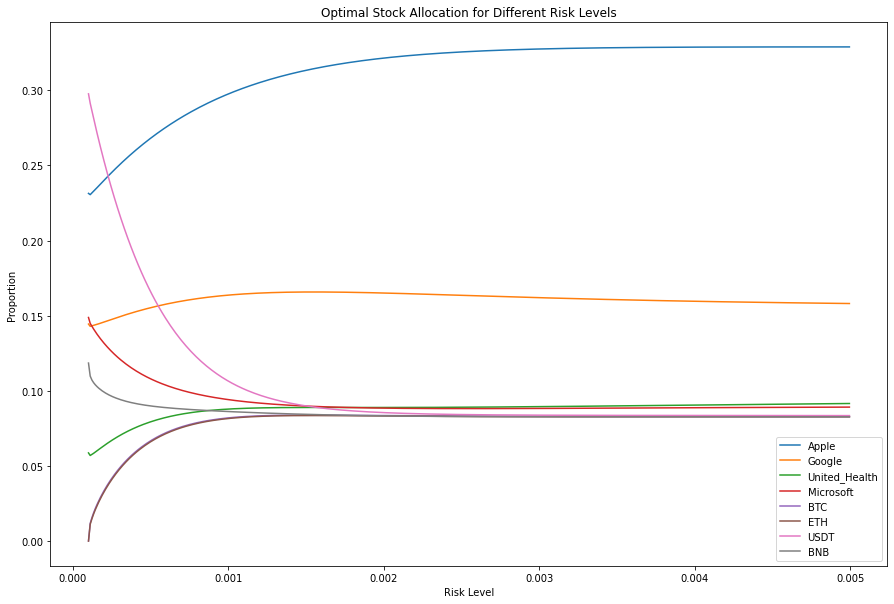

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = [ 'Apple', 'Google', 'United_Health', 'Microsoft', 'BTC','ETH','USDT','BNB']
param_analysis.plot(figsize=(15,10))
plt.xlabel('Risk Level')
plt.ylabel('Proportion')
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

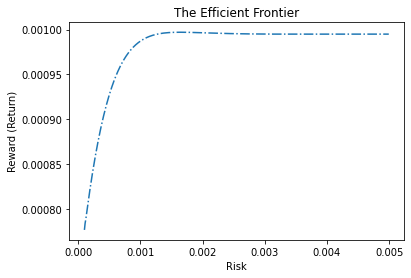

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

# Conclusions




1.  Certain stocks like Apple, Google and Microsoft displayed high correlation whilst USDT is negatively correlated with mostly all of the stocks and cryptocurrencies, that we selected. This shows that USDT prices always go in the other direction when compared with majority of the stock market prices.

2.  In terms of risk, United Health has the highest volatility as compared with other stocks. Cryptocurrencies in general have a higher volatility than the stock prices with BNB being the most volatile. 

3. According the Efficient Frontier in optimization model, the reward is maximised with a return of 0.03 when the risk is at 0.003. The reward seems stable from there on. According to the Efficient Frontier from our analysis, the highest return of 0.001 comes at the risk of approximately 0.001.

4. The portfolio selected by our model provide a even or higher return and lower volatility than the Dow Jones index. The average return of Dow is 0.011, and the volatility is 0.0652.

5. In order to choose the right combination for a portfolio, it is important to first consider a portfolio owner's risk-reward expectation. A risk averse person might want to choose a portfolio that comes from our analysis with the Efficient Frontier displaying a maximum return of 0.001 with a lower risk of 0.001, as show in our second efficient frontier plot. However, a person that is willing to take on more risk would want to consider the Efficient Frontier that comes from our optimization model that gives a higher return of 0.003 with a higher risk of 0.003, as shown in our first efficient frontier plot.
